In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
full_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mtsamples.csv')
full_data = full_data.dropna(subset=['description', 'transcription', 'medical_specialty']).reset_index(drop=True) # Выбросим None из интересующих колонок
full_data['description'] = full_data['description'].str.lower() # Преобразуем текст к нижнему регистру
full_data['transcription'] = full_data['transcription'].str.lower()
full_data["medical_specialty"] = full_data["medical_specialty"].str.strip() # Удаляем пробелы

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Исключение общих категории
general_categories_rows = full_data["medical_specialty"].isin(["Surgery", 'SOAP / Chart / Progress Notes', 'Office Notes', 'Consult - History and Phy.', 'Emergency Room Reports', 'Discharge Summary', 'Pain Management', 'General Medicine'])
data = full_data.drop(full_data[general_categories_rows].index)
data = data.reset_index(drop=True)
# Слияние в одну категорию
data["medical_specialty"] = data["medical_specialty"].str.replace("Neurosurgery", "Neurology")
data['medical_specialty'] = pd.Categorical(data['medical_specialty'])
# Добавление нового столбца
data['labels'] = data['medical_specialty'].cat.codes
categories_mapping = dict(enumerate(data['medical_specialty'].cat.categories))
# Выбераем только 5 категорий с наибольшим числом наблюдений.
top_categories_num = 5
cause_dist = data['medical_specialty'].value_counts()[0:top_categories_num]
cause_dist_unseen_cat = data['medical_specialty'].value_counts()[top_categories_num:]
# Определяем оставшиеся категории
test_unseen_categories = data[data["medical_specialty"].isin(cause_dist_unseen_cat.keys())]
test_unseen_categories = test_unseen_categories.reset_index(drop=True)
# Берем только те категории, у которых наблюдений больше 50
unseen_categories_groups = test_unseen_categories.groupby(test_unseen_categories['medical_specialty'])
test_unseen_categories = unseen_categories_groups.filter(lambda x:x.shape[0] > 50)
# Создание словаря для выбранных категорий
unseen_categories_mapping = dict(enumerate(test_unseen_categories['medical_specialty'].cat.categories))
# Оставляем в основном DataFrame наблюдения, которые принадлежат топ 5 категориям, и сбрасываем индексы.
data = data[data["medical_specialty"].isin(cause_dist.keys())]
data = data.reset_index(drop=True)

medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Name: count, dtype: int64
medical_specialty
Cardiovascular / Pulmonary    371
Orthopedic                    355
Neurology                     317
Radiology                     273
Gastroenterology              224
Name: co

(-1.0999951247597746,
 1.0999997678457036,
 -1.0999991955560877,
 1.099999512144392)

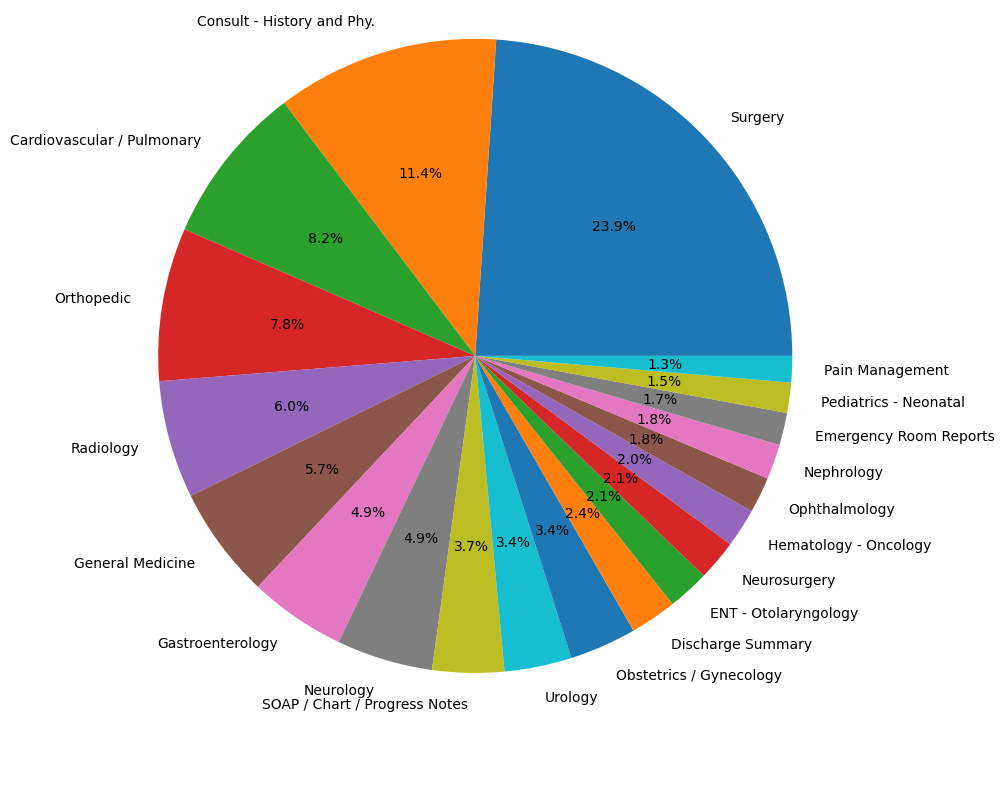

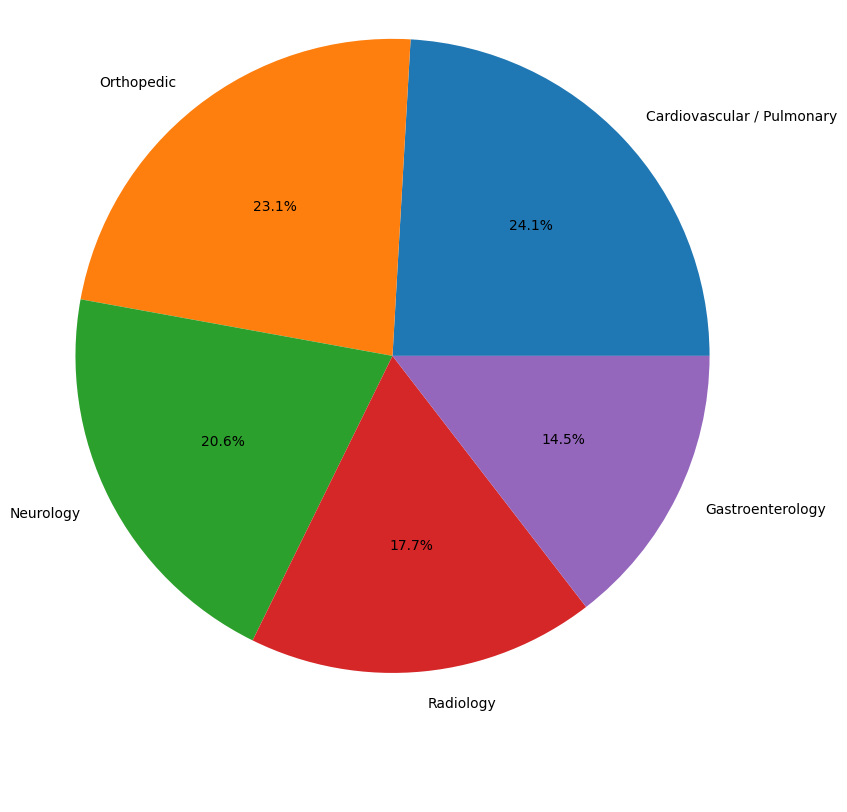

In [ ]:
import matplotlib.pyplot as plt

cause_dist = full_data['medical_specialty'].value_counts()[0:20]
print(cause_dist)
plt.figure(figsize=(9,9))
plt.title(' ', y=-0.15)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%")
plt.axis('equal')
# Выбранные категории
cause_dist = data['medical_specialty'].value_counts()[0:top_categories_num]
print(cause_dist)
plt.figure(figsize=(9,9))
plt.title(' ', y=-0.15)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%")
plt.axis('equal')

In [ ]:
from sklearn.model_selection import train_test_split
# Разделим данные на обучающую, валидационную и тестовую выборки
train_text, temp_text, train_labels, temp_labels = train_test_split(data['description'], data['labels'],random_state=42, test_size=0.3, stratify=data['labels'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=42, test_size=0.5, stratify=temp_labels)

unseen_train_text, unseen_test_text, unseen_train_labels, unseen_test_labels = train_test_split(test_unseen_categories['description'], test_unseen_categories['labels'], random_state=42, test_size=0.2, stratify=test_unseen_categories['labels'])

# notebook_medical_transcriptions.ipynb

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns
import plotly.graph_objects as go

from sklearn.decomposition import PCA
import plotly.express as px

from collections import Counter

import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import transformers

from transformers import AutoModel, AutoTokenizer , BertTokenizerFast
from transformers import AdamW

# from pytorch_metric_learning import losses

from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.svm import SVC
# Загрузка (stopwords). Стоп-слова — это слова по типу ("и", "в", "на"), которые удаляются из текста.
# Загрузка данных, необходимые для токенизации текста. Пакет punkt содержит модели для разделения текста на предложения и слова.
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
MAX_SENTENCE_LENGTh = 70 # Установка максимальной длины предложения для токенизации
# Load the BERT tokenizer
model_name = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext' # Загрузка предобученной модели BERT
#('bert-base-uncased')   'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
tokenizer = BertTokenizerFast.from_pretrained(model_name) # Загрузка предобученного токенизатора

# Longformer toknizer
#model_name = "allenai/longformer-base-4096"
#tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenize and encode sequences in the sets set
texts = [train_text, val_text, test_text, unseen_train_text, unseen_test_text] # Список текстов для токенизации
tokens_texts = [] # Список для хранения токенизированных текстов.

for text in texts: # Токенизация текстов - разбиение текста на слова как отдельные элементы
    tokens_texts.append(tokenizer.batch_encode_plus(text.tolist(),max_length = MAX_SENTENCE_LENGTh, padding='max_length', truncation=True))

train_tokinized, val_tokinized, test_tokinized, unseen_train_tokinized, unseen_test_tokinized = tokens_texts # Разделение токенизированных данных

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
def convert_to_tensors(data, labels): # Преобразование токенизированных данных и меток (labels) в тензоры PyTorch, для дальнейшего обучения и оценки модели.

    seq = torch.tensor(data['input_ids'])
    mask = torch.tensor(data['attention_mask'])
    y = torch.tensor(labels.tolist())

    return seq, mask, y

train_seq, train_mask, train_y  = convert_to_tensors(train_tokinized, train_labels)
val_seq, val_mask, val_y  = convert_to_tensors(val_tokinized, val_labels)
test_seq, test_mask, test_y  = convert_to_tensors(test_tokinized, test_labels)

unseen_train_seq, unseen_train_mask, unseen_train_y  = convert_to_tensors(unseen_train_tokinized, unseen_train_labels)
unseen_test_seq, unseen_test_mask, unseen_test_y  = convert_to_tensors(unseen_test_tokinized, unseen_test_labels)

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Определение двух классов ContrastiveDataset и SimpleDataset для подготовка данных для обучения моделей.
# ContrastiveDataset предназначен для генерации новых образцов текста из двух текстов одного класса.
# SimpleDataset загружает список данных в порядке их представления выборки.
class ContrastiveDataset(Dataset):

    def __init__(self, train_seq, train_mask, train_y, positive_prob=0.5):

        super().__init__()
        self.train_seq = train_seq
        self.train_mask = train_mask
        self.train_y = train_y
        self.positive_prob = positive_prob # probability to sample two texts with the same category

        self.hash_table = {} # format: {"category" : [i1, i2, ...]}

        # construct a hash table, each key is a category
        # and the value is a list of the indexs of the texts which belong to this category
        for i in range(len(self.train_seq)):
            label = self.train_y[i].item()
            if label in self.hash_table:
                self.hash_table[label].append(i)
            else:
                self.hash_table[label] = [i]


    def __getitem__(self, index):
        """
        Sample two texts from the same category with probability self.positive_prob
        :param index: index (int)
        :return:  seq_0 - a sequence of IDs (each ID represent a word in the vocabulary)
                  seq_1 - a sequence which differnt from seq0 (different text)
                  mask_0 - attention mask for seq1
                  mask_1 - attention mask for seq1
                  same_class - 1 if seq0 and seq1 are both from the same category, 0 otherwise
        """
        same_class = random.uniform(0, 1)
        same_class = same_class > self.positive_prob

        seq_0 = self.train_seq[index]
        mask_0 = self.train_mask[index]
        label_0 = self.train_y[index].item()
        class_samples = self.hash_table[label_0]

        if len(class_samples) < 2: # handle the case where there are only a single text in some category (in this case we can't draw another text from this category...)
            same_class = False

        if same_class:
            while True:
                rnd_idx = random.randint(0, len(class_samples) - 1)
                index_1 = class_samples[rnd_idx]
                if index_1 != index:
                    seq_1 = self.train_seq[index_1]
                    mask_1 = self.train_mask[index_1]
                    label_1 = self.train_y[index_1].item()
                    break
        else:
            while True:
                index_1 = random.randint(0, self.__len__() - 1)
                if index_1 != index:
                    seq_1 = self.train_seq[index_1]
                    mask_1 = self.train_mask[index_1]
                    label_1 = self.train_y[index_1].item()
                    if label_1 !=  label_0:
                        break

        return seq_0, seq_1, mask_0, mask_1, torch.tensor(same_class, dtype=torch.float)

    def __len__(self):  # Возвращает количество текстов в наборе данных
        return len(self.train_seq)

class SimpleDataset(Dataset): # Предназначен для простого обучения классификации, где каждый элемент набора данных представлен отдельно

    def __init__(self, seq, mask, y, positive_prob=0.5):

        super().__init__()
        self.seq = seq
        self.mask = mask
        self.y = y


    def __getitem__(self, index): # Возвращает последовательность токенов, маску и метку класса для заданного индекса
        """
        Sample texts by the order of the training set.
        :param index: index (int)
        :return: seq - a sequence of IDs (each ID represent a word in the vocabulary)
                 mask - attention mask for seq
                 y - the category of this text

        """
        return   self.seq[index], self.mask[index], torch.tensor(self.y[index].item())

    def __len__(self):  # Возвращает количество текстов в наборе данных
        return len(self.seq)

In [ ]:
# Создание наборов данных для обучения, валидации и тестирования с использованием ContrastiveDataset.
train_set = ContrastiveDataset(train_seq, train_mask,  train_y)
val_set = ContrastiveDataset(val_seq, val_mask, val_y)
test_set = ContrastiveDataset(test_seq, test_mask,test_y)
# Создание наборов данных для обучения и тестирования с использованием SimpleDataset
train_set_simple = SimpleDataset(train_seq, train_mask,  train_y)
test_set_simple = SimpleDataset(test_seq, test_mask,  test_y)
unseen_train_set_simple = SimpleDataset(unseen_train_seq, unseen_train_mask,  unseen_train_y)
unseen_test_set_simple = SimpleDataset(unseen_test_seq, unseen_test_mask,  unseen_test_y)

In [ ]:
# Создание загрузчиков данных для дальнейшего обучения
trainLoader = DataLoader(train_set, batch_size=32, shuffle=True,  drop_last=False, num_workers=0)
valLoader = DataLoader(val_set, batch_size=32, shuffle=True,  drop_last=False, num_workers=0)
testLoader = DataLoader(test_set, batch_size=10, shuffle=False,  drop_last=False, num_workers=0)

trainLoader_simple = DataLoader(train_set_simple, batch_size=32, shuffle=False,  drop_last=False, num_workers=0)
testLoader_simple = DataLoader(test_set_simple, batch_size=64, shuffle=False,  drop_last=False, num_workers=0)
unseen_trainLoader_simple = DataLoader(unseen_train_set_simple, batch_size=64, shuffle=False,  drop_last=False, num_workers=0)
unseen_testLoader_simple = DataLoader(unseen_test_set_simple, batch_size=64, shuffle=False,  drop_last=False, num_workers=0)

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # For cls_hs output (First token embedding)

      #self.fc1 = nn.Linear(768,512)
      #self.dropout = nn.Dropout(0.1)
      #self.relu =  nn.ReLU()
      #self.fc2 = nn.Linear(512,128)

      # For hs output (all tokens embeddings)
      # https://chriskhanhtran.github.io/posts/cnn-sentence-classification/
      self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, stride=1) # kernal_size=3 == three-grams
      self.avg_pooling = nn.AvgPool1d(kernel_size=2)
      self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=1)
      self.flatten = nn.Flatten()
      self.fc = nn.Linear(64,128)
      self.dropout = nn.Dropout(0.2)

      # Other options:
      #Mean of the token embeddings
      #Max of the token embedding

    def forward(self, seq, mask):

      # Explaination on BERT and its outputs:
      # https://towardsdatascience.com/tips-and-tricks-for-your-bert-based-applications-359c6b697f8e
      # To sum up: BERT is a transformer encoder, meanning it produces representations of the inputs, and hence we can use it for several tasks.

      # BERT returns a dictionary of vectors where the first is called 'sequence output' (or 'hidden state'=hs) and the other is 'pooled output' (or 'cls_hs').
      # ** 'sequence_output' is of shape [batch_size, max_seq_length, 768] with representations for each input token (including start symbol and end symbol)
      # ** 'pooled_output' is of shape [batch_size, 768] with representations for the entire input sequences. It created by taking only the first token embedded vector (start symbol)
      #     (and pass it throgh more layers (?))

      # The idea of "pooled_output":
      # Since, the embeddings from the BERT model at the output layer are known to be contextual embeddings, the output of the 1st token, i.e, [CLS] token
      # would have captured sufficient context. Hence, the authors of BERT paper found it sufficient to use only the output from the 1st token for few tasks
      # such as classification. They call this output from the single token (i.e, 1st token) as pooled_output.

      # Get embeddings from bert.
      # Output shape: hs = (b, max_len_seq, embed_dim)
      #               cls = (b, embed_dim)
      # where:  b: batch_size
      #         max_len_seq=number of tokens in the longest text (we defined it erilier)
      hs, cls_hs = self.bert(seq, attention_mask=mask, return_dict=False)

      #x = self.fc1(cls_hs)
      #x = self.dropout(x)
      #x = self.relu(x)
      #x = self.fc2(x)


      x = hs.permute(0, 2, 1).contiguous()          # Permute `hs` to match input shape requirement of `nn.Conv1d`
                                                    # The contiguous() ensures the memory of the tensor is stored contiguously
                                                    # which helps avoid potential issues during processing.
                                                    # Output shape: (b, 768, 70) = (b, embed_dim, max_len_seq).

      x = F.relu(self.conv1(x))                     # Output shape: (b, 128, *)  * depends on kernel size and padding
      x = self.avg_pooling(x)                       # Output shape: (b, 128, *)
      x = F.relu(self.conv2(x))                     # Output shape: (b, 128, *)
      x = F.max_pool1d(x, kernel_size=x.shape[2])   # Output shape: (b, 128, 1) # trick: we use kernel of size x.shape[2] to reduce from * to 1
      x = self.flatten(x)                           # Output shape: (b, 128)
      x = self.fc(x)                                # Output shape: (b, 128)
      x = self.dropout(x)

      return x


class SiameseNeuralNetwork(nn.Module):

    def __init__(self, bert_arch):
        super().__init__()            # TODO super?

        self.bert_arch = bert_arch
        self.distance_layer = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())  # if we would use BCEWithLogitsLoss as loss function, we should delte the sigmoid since we dont need it after the linear layer a sigmoid layer


    def forward(self, seq1, seq2, mask1, mask2):
        feature_vec1 = self.bert_arch(seq1, mask1) # feature_vec1 shape:  [batch_size, embedding_size]
        feature_vec2 = self.bert_arch(seq2, mask2)
        difference = torch.abs(feature_vec1 - feature_vec2)
        out = self.distance_layer(difference)
        return out #feature_vec1, feature_vec2#out


class ContrastiveLoss(nn.Module):
    """
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() *  torch.nn.functional.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [ ]:
def train_siamese_network(model, dataloaders, num_epochs, device):
    """
    Train the given SNN model.

    :param model: SNN model
    :param dataloaders: a dict that contains train data loader and validation data loader
    :param num_epochs: number of epochs
    :param device: 'cpu' or 'cuda'

    :return:  train_loss_history - list of train losses by epochs
              val_loss_history -  list of validation losses by epochs

    """
    train_loss_history = []
    val_loss_history = []
    matching_similarity = []
    non_matching_similarity = []

    val_matching_similarity = []
    val_non_matching_similarity = []

    criterion = torch.nn.BCELoss(reduction='mean') #ContrastiveLoss(margin=1)  #losses.ContrastiveLoss(pos_margin=0, neg_margin=1) # torch.nn.BCEWithLogitsLoss(reduction='mean') # the labels are same class (1) vs. different class (0)
    learning_rate = 0.005 # 0.005 # 0.1
    optimizer  =  AdamW(model.parameters(),lr =learning_rate)#torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # AdamW(model.parameters(),lr =learning_rate)  1e-5

    # lr = lr * factor
    # mode='min': look for the min validation loss to track
    # patience: number of epochs - 1 where loss plateaus before decreasing LR
    # patience = 0, after 1 bad epoch, reduce LR
    # factor: decaying factor

    #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True, min_lr=0.0001)  ########################################################
    #cyclic_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.1, cycle_momentum=False) ########################################################

    for epoch in range(num_epochs):  # loop over the train dataset multiple times

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for i, batch in enumerate(dataloaders[phase]):

                  seq1, seq2, mask1, mask2, label = batch

                  if device == 'cuda':
                    seq1, seq2, mask1, mask2, label = seq1.to(device), seq2.to(device), mask1.to(device), mask2.to(device), label.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # track history  only in train
                  with torch.set_grad_enabled(phase == 'train'):

                      # forward
                      output = model.forward(seq1, seq2, mask1, mask2)
                      loss = criterion(output, label.view(output.size())) # criterion(output.squeeze(0), label.view(1))    label.view((trainLoader.batch_size,1))

                      # backward + optimize only if in training phase
                      if phase == 'train': #  with torch.no_grad() if phae == 'val'?
                          loss.backward()
                          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
                          optimizer.step()
                          #cyclic_scheduler.step() ########################################################

                          # save similarity scores for training data
                          output = output.cpu().detach().numpy()
                          label = label.cpu().numpy()
                          non_matching_similarity.append((sum(output[label == 0]) / sum(label == 0)).item())
                          matching_similarity.append((sum(output[label == 1]) / sum(label == 1)).item())

                      if phase == 'val':
                         val_non_matching_similarity.append((sum(output[label == 0]) / sum(label == 0)).item())
                         val_matching_similarity.append((sum(output[label == 1]) / sum(label == 1)).item())

                  running_loss += loss.item() * seq1.size(0)  #we multiply by the batch size (note that the batch size in the last batch may not be the batch size we did since the batch size dont necceraly divide the train size)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
               train_loss_history.append(epoch_loss)
            else:
               val_loss_history.append(epoch_loss)
               #scheduler.step(epoch_loss) ########################################################

            print('Epoch {} | {} loss: {:.3f}'.format(epoch, phase, epoch_loss))


    return train_loss_history, val_loss_history, [non_matching_similarity, matching_similarity, val_non_matching_similarity, val_matching_similarity]

In [ ]:
# specify GPU
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# import BERT-base pretrained model
bert = AutoModel.from_pretrained(model_name)   # ('bert-base-uncased') 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# pass the pre-trained BERT to our define architecture
bert_arch = BERT_Arch(bert)

SNN_model = SiameseNeuralNetwork(bert_arch).to(device)
num_epochs = 30

train_loss_history, val_loss_history, similarities_list = train_siamese_network(SNN_model, dataloaders={"train":trainLoader, "val":valLoader},  num_epochs=num_epochs, device=device)

non_matching_similarity, matching_similarity, val_non_matching_similarity, val_matching_similarity = similarities_list

Using cuda device


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


Epoch 0 | train loss: 0.663
Epoch 0 | val loss: 0.638
Epoch 1 | train loss: 0.612
Epoch 1 | val loss: 0.642
Epoch 2 | train loss: 0.634
Epoch 2 | val loss: 0.668
Epoch 3 | train loss: 0.604
Epoch 3 | val loss: 0.568
Epoch 4 | train loss: 0.600
Epoch 4 | val loss: 0.625
Epoch 5 | train loss: 0.613
Epoch 5 | val loss: 0.661
Epoch 6 | train loss: 0.584
Epoch 6 | val loss: 0.582
Epoch 7 | train loss: 0.573
Epoch 7 | val loss: 0.521
Epoch 8 | train loss: 0.557
Epoch 8 | val loss: 0.535
Epoch 9 | train loss: 0.551
Epoch 9 | val loss: 0.546
Epoch 10 | train loss: 0.557
Epoch 10 | val loss: 0.576
Epoch 11 | train loss: 0.545
Epoch 11 | val loss: 0.556
Epoch 12 | train loss: 0.542
Epoch 12 | val loss: 0.522
Epoch 13 | train loss: 0.548
Epoch 13 | val loss: 0.625
Epoch 14 | train loss: 0.528
Epoch 14 | val loss: 0.524
Epoch 15 | train loss: 0.528
Epoch 15 | val loss: 0.744
Epoch 16 | train loss: 0.511
Epoch 16 | val loss: 0.587
Epoch 17 | train loss: 0.485
Epoch 17 | val loss: 0.717
Epoch 18 | t

In [ ]:
def plot_losses(train_loss_history, val_loss_history, num_epochs):

    fig = go.Figure()

    line_color = [px.colors.qualitative.Light24[5], px.colors.qualitative.Light24[4]]


    fig.add_trace(go.Scatter(x=list(range(1, num_epochs+1)), y=train_loss_history, mode='lines', line=dict(color=line_color[0], width=1), name="train loss"))
    fig.add_trace(go.Scatter(x=list(range(1, num_epochs+1)), y=val_loss_history, mode='lines',line=dict(color=line_color[1], width=1), name="valdiation loss")) #opacity=0.8

    fig.update_yaxes(range=[0, 1])
    fig.update_traces(textposition='top center')
    fig.update_layout(autosize=False,width=900, height=500, title_text="SNN Loss", title_x=0.5, xaxis_title="Epoch", yaxis_title="", xaxis = dict(tickmode='linear', tick0=1, dtick=1), legend=dict(yanchor="top",xanchor="right", x=1.35, y=1),template="plotly_dark")
    fig.show()

In [ ]:
plot_losses(train_loss_history, val_loss_history, num_epochs)

In [ ]:
def plot_similarity_scores(non_matching_similarity, matching_similarity):

    train_num_batchs = len(non_matching_similarity)

    fig = go.Figure()

    line_color = [px.colors.qualitative.Light24[22], px.colors.qualitative.Light24[19]]


    fig.add_trace(go.Scatter(x=list(range(1, train_num_batchs+1)), y=non_matching_similarity, mode='lines', line=dict(color=line_color[0], width=1), name="unmatching categories"))
    fig.add_trace(go.Scatter(x=list(range(1, train_num_batchs+1)), y=matching_similarity, mode='lines',line=dict(color=line_color[1], width=1), name="matching categories")) #opacity=0.8

    fig.update_yaxes(range=[0, 1])
    fig.update_traces(textposition='top center')
    fig.update_layout(autosize=False,width=900, height=500, title_text="Similarity Scores", title_x=0.5, xaxis_title="Batch", yaxis_title="", legend=dict(yanchor="top",xanchor="right", x=1.35, y=1),template="plotly_dark")
    fig.show()

In [ ]:
plot_similarity_scores(non_matching_similarity, matching_similarity)

In [ ]:
plot_similarity_scores(val_non_matching_similarity, val_matching_similarity)

In [ ]:
# print all layers in the model that are participating in the learning process
for name, param in SNN_model.named_parameters():
    if param.requires_grad:
        print(name)

bert_arch.conv1.weight
bert_arch.conv1.bias
bert_arch.conv2.weight
bert_arch.conv2.bias
bert_arch.fc.weight
bert_arch.fc.bias
distance_layer.0.weight
distance_layer.0.bias


In [ ]:
def construct_train_matrix(SNN_model, trainLoader_simple):
    """
    Embed the training data using the trained SNN model.
    """

    # Get intermidate layer output.
    # Source: https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/2
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # SNN_model.bert_arch.fc1.register_forward_hook(get_activation('fc1'))
    SNN_model.bert_arch.fc.register_forward_hook(get_activation('fc'))

    train_matrix = []
    print("num batches:", len(trainLoader_simple))
    with torch.no_grad():
        for i, batch in enumerate(trainLoader_simple):
            print(i, "/", len(trainLoader_simple), " batches")
            seq1, mask1, label1 = batch
            if device == 'cuda':
                seq1, mask1, label1 = seq1.to(device), mask1.to(device), label1.to(device)

            SNN_model.eval()
            output = SNN_model(seq1, seq1, mask1, mask1)
            train_matrix.append(activation['fc'].cpu().numpy()) # activation['fc1'] return a tensor in cuda with size (batch_size, embedding_dim), so we move it to cpu, than to numpy array.

    return np.vstack(train_matrix) # we combine all the batches, so now we return matrix of size (num_samples_train, embedding_dim)

def extract_prototypes(k, SNN_model, trainLoader_simple, train_labels, train_matrix):
    """
    Compute kc (= k/num_classes_train) prototypes for each class in the trainset.
    (if k % num_classes_train != 0 then take the highest k0 <= k which is divisable by num_classes_train)

    :param k:
    :param train_matrix: size (num_samples_train, embedding_dim)
    :return:
    """
    train_labels = list(train_labels)
    train_dataset = trainLoader_simple.dataset  # contains triples of (seq, mask, label)

    # construct a hash table, each key is a class of diagnosis
    # and the value is a list of the indexs of the sentences which belong to this class
    hash_table = {} # format: {"diagnosis" : [i1, i2, ...]}
    for i in range(len(train_labels)):
        lbl = train_labels[i]
        if lbl in hash_table:
            hash_table[lbl].append(i)
        else:
            hash_table[lbl] = [i]


    # Create prototypess
    prototypes_list = {diagnosis:[] for diagnosis in hash_table.keys()}
    num_classes_train = len(hash_table)
    assert k >= num_classes_train, "k should be greater than the numbrer of uniqe labels in the train set'"
    kc = int(k / num_classes_train)
    print("kc:", kc)

    for diagnosis in hash_table.keys():

      print("diagnosis:", diagnosis)

      if len(hash_table[diagnosis]) <= 1 : # if there is only a single sentence in some diagnosis sentences list - take it as the prototype of this class
          prototypes_list += list(train_matrix[hash_table[diagnosis]])

      else:
          # fit on all sentences which belongs to the same class (diagnosis)
          kmeans = KMeans(n_clusters=kc, init='k-means++').fit(train_matrix[hash_table[diagnosis]])
          # extract for each centroid the closest real sample, and add it as a prototype
          for centroid in kmeans.cluster_centers_:
             #print(train_matrix[hash_table[diagnosis]].shape)
             best_match_index = None
             best_match_dist = float('inf')
             for sentence_index in hash_table[diagnosis]:
                 #print(sentence_index)
                 embedded_sent = train_matrix[sentence_index]
                 dist = distance.euclidean(centroid, embedded_sent)
                 #print("dist:", best_match_dist)
                 if dist < best_match_dist:
                    best_match_dist = dist
                    best_match_index = sentence_index
             #print(best_match_index)
             prototypes_list[diagnosis].append(train_dataset[best_match_index])

    return prototypes_list

In [ ]:
train_matrix = construct_train_matrix(SNN_model, trainLoader_simple)

num batches: 34
0 / 34  batches
1 / 34  batches
2 / 34  batches
3 / 34  batches
4 / 34  batches
5 / 34  batches
6 / 34  batches
7 / 34  batches
8 / 34  batches
9 / 34  batches
10 / 34  batches
11 / 34  batches
12 / 34  batches
13 / 34  batches
14 / 34  batches
15 / 34  batches
16 / 34  batches
17 / 34  batches
18 / 34  batches
19 / 34  batches
20 / 34  batches
21 / 34  batches
22 / 34  batches
23 / 34  batches
24 / 34  batches
25 / 34  batches
26 / 34  batches
27 / 34  batches
28 / 34  batches
29 / 34  batches
30 / 34  batches
31 / 34  batches
32 / 34  batches
33 / 34  batches


In [ ]:
prototypes_list = extract_prototypes(100, SNN_model, trainLoader_simple, train_labels, train_matrix)

kc: 20
diagnosis: 26
diagnosis: 21


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



diagnosis: 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



diagnosis: 11


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



diagnosis: 18


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding

def show_space(X, title, colors=None, color_by="", show_3D=False):

  if show_3D:
    dictionary = dict(zip(pd.DataFrame(X).columns, ["COMP1", "COMP2", "COMP3"]))
    temp_df = pd.DataFrame(X).rename(columns=dictionary)
    fig = px.scatter_3d(temp_df, x='COMP1', y='COMP2', z='COMP3',color=colors, template="plotly_dark", labels={"color": color_by})
  else:
    dictionary = dict(zip(X.columns, ["COMP1", "COMP2"]))
    temp_df = pd.DataFrame(X).rename(columns=dictionary)
    fig = px.scatter(temp_df, x='COMP1', y='COMP2',color=colors, template="plotly_dark", labels={"color": color_by})

  fig.update_traces(marker=dict(size=4, opacity=0.98), textposition='top center')
  fig.update_layout(title_text=title, title_x=0.5, autosize=False,width=900, height=500, legend=dict(yanchor="top",xanchor="right", x=1.1, y=1))
  fig.show()
  #fig.write_html("file.html")

In [ ]:
print(train_labels.shape)
print(type(train_labels))

(1078,)
<class 'pandas.core.series.Series'>


In [ ]:
pca_alg = PCA(n_components=3)
X_pca = pca_alg.fit_transform(train_matrix)
#show_space(X_pca, title="3D Space", colors=pd.DataFrame(train_labels).replace(categories_mapping).values, color_by="category", show_3D=True)
show_space(X_pca, title="3D Space", colors=train_labels.replace(categories_mapping).values, color_by="category", show_3D=True)

In [ ]:
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.66153467 0.17963573 0.05921539]
Comulative explained variance: [0.66153467 0.84117043 0.9003858 ]


In [ ]:
def project_to_dissimilarity_space(dataLoader, SNN_model, prototypes_list):
    """

    Parameters
    ----------
    dataLoader :
    SNN_model :


    Returns
    -------
    projected_data : numpy array of shape (num_samples_data, projection_dim)
    """

    projected_data = []
    with torch.no_grad():

        for batch in dataLoader:
            print("****new batch***")

            projected_sentence = []
            seq1, mask1, label1 = batch
            if device == 'cuda':
                seq1, mask1, label1 = seq1.to(device), mask1.to(device), label1.to(device)

            for diagnosis in prototypes_list:
                #print("diagnosis:", diagnosis)
                for centroid in prototypes_list[diagnosis]: # centroid contains a triple of (seq, mask, label)
                    seq2, mask2 = centroid[0].repeat(seq1.shape[0], 1), centroid[1].repeat(mask1.shape[0], 1)  # we stack to seq2 and mask2 replications of them such that they will fit the batch size of seq1 and mask2
                    if device == 'cuda':
                       seq2, mask2 = seq2.to(device), mask2.to(device)

                    SNN_model.eval()
                    distance = SNN_model(seq1, seq2, mask1, mask2)
                    projected_sentence.append(distance.squeeze().cpu().numpy())

            projected_data.append(np.array(projected_sentence).T)
            #break # TODO delete

    projected_data = np.vstack(projected_data)
    return projected_data

In [ ]:
projected_train = project_to_dissimilarity_space(trainLoader_simple, SNN_model, prototypes_list)

****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***


In [ ]:
projected_train.shape

(1078, 100)

In [ ]:
X_pca = pca_alg.fit_transform(projected_train)
#show_space(X_pca, title="3D Space", colors=pd.DataFrame(train_labels).replace(categories_mapping), color_by="category", show_3D=True)
show_space(X_pca, title="3D Space", colors=train_labels.replace(categories_mapping).values, color_by="category", show_3D=True)
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.6175557  0.20861778 0.11325215]
Comulative explained variance: [0.6175557 0.8261734 0.9394256]


# SVM

In [ ]:
def ensemble_of_classifiers(projected_train,  train_y):
    """
    For each category a classifier is trained to discriminate between this category and all the other categories put together.

    Parameters
    ----------
    projected_train : shape (num_samples_train, projection_dim)
    train_y : shape (num_samples_train)


    Returns
    -------
    classifiers_list : a list of trained classifiers. The it'h classifier desined to predict the i'th category.
    diagnosis_list : list of the categories order as the classifiers.
    """

    classifiers_list = []

    diagnosis_list = np.sort(list(Counter(list(train_y)).keys()))   # orderd by increasing order: (0,1,2,..)

    for diagnosis in diagnosis_list:
        print(diagnosis)

        y = np.zeros(len(train_y))
        is_diagnosis = train_y == diagnosis
        y[is_diagnosis] = 1
        y = y.astype('int')
        if y.sum() == 0: # TODO delete
          continue
        classifier = SVC(gamma='auto', probability=True)
        classifier.fit(projected_train, y)

        classifiers_list.append(classifier)

    return classifiers_list, diagnosis_list

In [ ]:
classifiers, categories_order = ensemble_of_classifiers(projected_train,  train_labels)

3
11
18
21
26


In [ ]:
projected_test = project_to_dissimilarity_space(testLoader_simple, SNN_model, prototypes_list)

****new batch***
****new batch***
****new batch***
****new batch***


In [ ]:
projected_test.shape

(231, 100)

In [ ]:
X_pca = pca_alg.fit_transform(projected_test)
#colors=train_labels.replace(categories_mapping).values
#colors_extended = np.tile(colors, len(X_pca) // len(colors) + 1)[:len(X_pca)]
#show_space(X_pca, title="3D Space", colors=pd.DataFrame(test_labels).replace(categories_mapping), color_by="category", show_3D=True)
show_space(X_pca, title="3D Space", colors=test_labels.replace(categories_mapping).values, color_by="category", show_3D=True)
#show_space(X_pca, title="3D Space", colors=colors_extended, color_by="category", show_3D=True)
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.6383662  0.17463072 0.1106813 ]
Comulative explained variance: [0.6383662 0.8129969 0.9236782]


In [ ]:
def predict(projected_test, classifiers_list, categories_order, test_labels):

    pred_y = []

    for classifier in classifiers_list:
         pred_y.append(classifier.predict_proba(projected_test)[:,1])    # predict_proba returns probabiltiy for class==0 and for class==1, so we take only the probabilities of class==1

    pred_y = np.vstack(pred_y) # (num_classifiers, num_samples_test)
    highest_predictions = categories_order[np.argmax(pred_y, axis=0)]
    print(pred_y)
    print(highest_predictions)
    return highest_predictions

In [ ]:
preds = predict(projected_test, classifiers, categories_order, test_labels)

[[0.86547572 0.01183908 0.87244261 ... 0.00175504 0.00116919 0.85884359]
 [0.00503807 0.94290538 0.00552101 ... 0.00427992 0.00549664 0.0079075 ]
 [0.02599063 0.03688786 0.02425314 ... 0.35010991 0.74371237 0.0233474 ]
 [0.03333285 0.0244538  0.03822213 ... 0.25559263 0.00727362 0.04280399]
 [0.16254871 0.16428762 0.16585262 ... 0.16764177 0.19617162 0.16815574]]
[ 3 11  3 18  3 21 18 11 21 18 21 18 18 18 18  3 18 18 18 18  3 11  3 18
 18  3  3 18  3 21 18 21 18 21 18  3  3 21 11 11 21  3 18 18 21  3 26 18
 18  3  3 11 21  3 11  3 21 21 18  3 18 18 18 21  3 18  3 18 11  3 21 11
 21 18 11 21  3  3 18  3 18 18 21 11 21  3  3  3 18 21  3  3 11 11 21 21
 18 18 18 18 11 26 21 18 18 21  3  3 21 21 11 18 21 18 21 18 18  3 21  3
 18 18 21 21 11 11 11  3  3 18  3 11 18 21 21 21  3 26 11 18  3 18 11 26
 18 18 26 18 21 18 18 21  3 21  3  3  3 21 21 18 21  3 26 21 18  3  3 18
  3  3  3 26 11 26 18 11 21 26  3  3 18 18 21  3  3 21 18 18 18 18 18 21
  3 18 11 11  3 11  3 21 21 11 21  3 21  3 18  3  

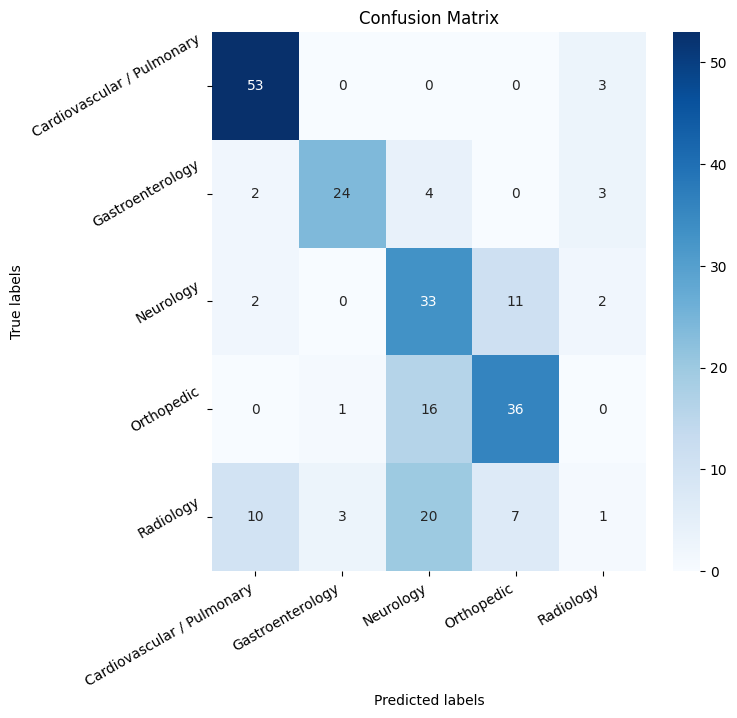

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(mat,fig_size, labels):

    fig = plt.figure(figsize=(fig_size,fig_size))
    ax= fig.add_subplot(1,1,1)
    sns.heatmap(mat, annot=True, cmap="Blues",ax = ax,fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.show()

c_matrix = confusion_matrix(test_labels, preds)
plot_confusion_matrix(c_matrix, fig_size=7, labels=[categories_mapping[c] for c in categories_order])

In [ ]:
from sklearn.metrics import classification_report
categories_labels = [categories_mapping[c] for c in categories_order]
print(classification_report(test_labels, preds, target_names=categories_labels))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.79      0.95      0.86        56
          Gastroenterology       0.86      0.73      0.79        33
                 Neurology       0.45      0.69      0.55        48
                Orthopedic       0.67      0.68      0.67        53
                 Radiology       0.11      0.02      0.04        41

                  accuracy                           0.64       231
                 macro avg       0.58      0.61      0.58       231
              weighted avg       0.58      0.64      0.60       231



# test unseen categories

In [ ]:
unseen_train_matrix = construct_train_matrix(SNN_model, unseen_trainLoader_simple)
unseen_prototypes_list = extract_prototypes(100, SNN_model, unseen_trainLoader_simple, unseen_train_labels, unseen_train_matrix)
unseen_projected_train = project_to_dissimilarity_space(unseen_trainLoader_simple, SNN_model, unseen_prototypes_list)
unseen_classifiers, unseen_categories_order = ensemble_of_classifiers(unseen_projected_train,  unseen_train_labels)

num batches: 10
0 / 10  batches
1 / 10  batches
2 / 10  batches
3 / 10  batches
4 / 10  batches
5 / 10  batches
6 / 10  batches
7 / 10  batches
8 / 10  batches
9 / 10  batches
kc: 12
diagnosis: 30
diagnosis: 19


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



diagnosis: 17
diagnosis: 9
diagnosis: 12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



diagnosis: 25
diagnosis: 22
diagnosis: 20
****new batch***


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
****new batch***
9
12
17
19
20
22
25
30


In [ ]:
unseen_projected_test = project_to_dissimilarity_space(unseen_testLoader_simple, SNN_model, unseen_prototypes_list)
unseen_preds = predict(unseen_projected_test, unseen_classifiers, unseen_categories_order, unseen_test_labels)

****new batch***
****new batch***
****new batch***
[[1.99360406e-02 1.51711675e-03 7.70972611e-04 ... 8.53982000e-02
  2.20060239e-01 5.44865943e-05]
 [5.67199567e-02 1.86816173e-01 1.08009213e-01 ... 1.80988307e-01
  9.01892535e-02 9.52361000e-02]
 [6.05109446e-02 1.25684142e-01 1.32063933e-01 ... 1.80677602e-01
  1.41996355e-01 1.65225640e-01]
 ...
 [1.14308128e-01 1.45335435e-01 9.71237554e-02 ... 9.55355685e-02
  1.11088636e-01 9.84995822e-02]
 [2.78821238e-03 3.03473424e-02 1.37125207e-02 ... 2.73207481e-02
  1.22428982e-01 4.41577930e-02]
 [2.65977856e-02 1.62160254e-01 2.89036123e-01 ... 2.25387513e-01
  1.37143865e-01 1.65412452e-01]]
[19 12 30 19  9 30 12 30 22 30  9 30 30 19 30 19 20 19 19 19 19 17 30 20
  9 25 19  9  9  9  9 19 30 30 30 20 20 30 30 19 30 19 19 30 30  9 30 30
 20 30 30 19 20 30  9 19 30 20 30 12 17 30 19  9  9  9 30  9 30 30 30 30
 20 30 17 19 30 30 30 25  9 19 30 30 25 30 30  9 30 30  9 30 19 30 30 19
 25 25  9 19 30 25 30 19 19  9 19  9 30 19 19 30 19 20 12

In [ ]:
len(unseen_projected_test)

157

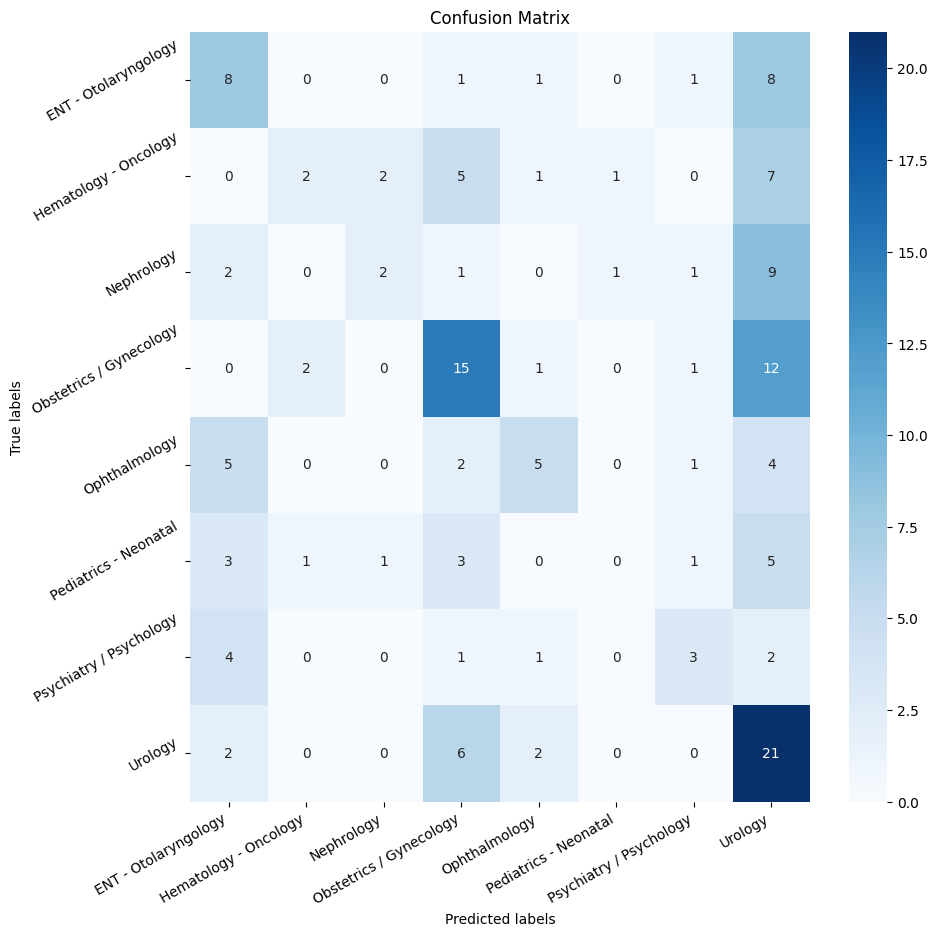

In [ ]:
unseen_c_matrix = confusion_matrix(unseen_test_labels, unseen_preds)
plot_confusion_matrix(unseen_c_matrix, fig_size=10, labels=[unseen_categories_mapping[c] for c in unseen_categories_order])

In [ ]:
Counter(unseen_train_labels)

Counter({30: 125, 19: 124, 17: 65, 9: 77, 12: 72, 25: 42, 22: 56, 20: 66})

In [ ]:
unseen_categories_labels = [unseen_categories_mapping[c] for c in unseen_categories_order]
print(classification_report(unseen_test_labels, unseen_preds, target_names=unseen_categories_labels))

                         precision    recall  f1-score   support

   ENT - Otolaryngology       0.33      0.42      0.37        19
  Hematology - Oncology       0.40      0.11      0.17        18
             Nephrology       0.40      0.12      0.19        16
Obstetrics / Gynecology       0.44      0.48      0.46        31
          Ophthalmology       0.45      0.29      0.36        17
  Pediatrics - Neonatal       0.00      0.00      0.00        14
Psychiatry / Psychology       0.38      0.27      0.32        11
                Urology       0.31      0.68      0.42        31

               accuracy                           0.36       157
              macro avg       0.34      0.30      0.29       157
           weighted avg       0.35      0.36      0.32       157



In [ ]:
X_pca = pca_alg.fit_transform(unseen_projected_train)
#show_space(X_pca, title="3D Space", colors=pd.DataFrame(unseen_train_labels).replace(categories_mapping), color_by="category", show_3D=True)
show_space(X_pca, title="3D Space", colors=unseen_train_labels.replace(categories_mapping).values, color_by="category", show_3D=True)
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.5748598  0.24908671 0.0648569 ]
Comulative explained variance: [0.5748598  0.8239465  0.88880336]


In [ ]:
X_pca = pca_alg.fit_transform(unseen_projected_test)
#show_space(X_pca, title="3D Space", colors=pd.DataFrame(unseen_test_labels).replace(categories_mapping), color_by="category", show_3D=True)
show_space(X_pca, title="3D Space", colors=unseen_test_labels.replace(categories_mapping).values, color_by="category", show_3D=True)
print("Explained variance per component:", pca_alg.explained_variance_ratio_)
print("Comulative explained variance:", pca_alg.explained_variance_ratio_.cumsum())

Explained variance per component: [0.57394934 0.233112   0.0804574 ]
Comulative explained variance: [0.57394934 0.8070613  0.8875187 ]
